<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/kalapa_4student_traditional_ML_ordinal_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout, BatchNormalization, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K
from tensorflow import feature_column as fc
from keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc
from sklearn.utils import check_random_state
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

import xgboost as xgb
from lightgbm import LGBMClassifier

%matplotlib inline

In [3]:
print(pd.__version__)
print(tf.__version__)

1.0.5
2.3.0


In [22]:
submision_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/simple_submission.csv'
train_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/train.csv'
test_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/test.csv'

added_data_path= '/content/drive/My Drive/Data/colabs_data/kalapa_4students/exdata.txt'

In [5]:
def load_data(train_path, test_path, label_col = 'label'):
    train_data = pd.read_csv(train_path)
    predict_data = pd.read_csv(test_path)
    return train_data, predict_data

train_data, predict_data = load_data( train_path, test_path )
train_data = train_data[train_data['label'].isin( [0,1] )].replace('notfound','missing')
predict_data = predict_data.replace('notfound','missing')
cols = train_data.columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [24]:
# train_data.merge()
added_data = pd.read_csv(added_data_path, sep='\t', encoding='utf-8')
added_data

,province,area,population,pop_density
0,Hà Nội,3358.6,8093.9,2410
1,Vĩnh Phúc,1235.9,1154.8,934
2,Bắc Ninh,822.7,1378.6,1676
3,Quảng Ninh,6178.2,1324.8,214
4,Hải Dương,1668.2,1896.9,1137
...,...,...,...,...
59,Cần Thơ,1439.0,1236.0,859
60,Hậu Giang,1621.7,732.2,451
61,Sóc Trăng,3311.9,1199.5,362
62,Bạc Liêu,2669.0,908.2,340


In [50]:
unique_check = train_data['currentLocationName'].unique()
for i in unique_check:
  print(i)

nan
Thành phố Hồ Chí Minh
Qui Nhon, Bình Ðịnh, Vietnam
Long Thành
Quang Nam, Quang Nam-Da Nang, Vietnam
Hà Nội
Quy Nhơn
Tân An
Ha Tin', Hà Tĩnh, Vietnam
Phù Cát
Anini-y, Antique
Đại Lộc
Thăng Bình
Хошимин
Kasongan, Kalimantan Tengah, Indonesia
Đà Nẵng
Thon Tu Thien, Thuin Hai, Vietnam
Duy Xuyên
Chicago
Thanh Binh (1), Quang Nam-Da Nang, Vietnam
Nong Son, Quang Nam-Da Nang, Vietnam
An Nhơn
Tam Kỳ
Da Nang, Vietnam
Quảng Ngãi (thành phố)
Phú Vang
Buôn Ma Thuột
Plei Bau Can, Gia Lai-Cong Tum, Vietnam
Xa Phan Thiet, Bình Thuận, Vietnam
Ho-Chi-Minh-Stadt
Quy Nhon
Quang Ngai
Ba Vì, Ha Son Binh, Vietnam
Pleiku
Long Xuyên
Quang Ninh, Binh Tri Thien, Vietnam
Tam Quan, Bình Ðịnh, Vietnam
Huế
Binh Dinh, Nghia Binh, Vietnam
Phu My, Nghia Binh, Vietnam
Hải Phòng
دا نانغ
Gò Vấp
Chu Lai, Quang Nam-Da Nang, Vietnam
مدينة هو تشي منه
Nam Định, Nam Định, Vietnam
Hội An
Yên Bái (thành phố)
Binh Duong, Quang Nam-Da Nang, Vietnam
Nha Trang
Hà Nhà (1), Quang Nam-Da Nang, Vietnam
Hoi An, Quang Nam-Da Nang, Vie

In [29]:
# Nhãn
cols_label = ['label']
# Đặc trưng binary
cols_fts_binary = [i for i in train_data.select_dtypes(include=['float64','int64']).columns 
                   if len(set(train_data[i].fillna(0)) - {0,1} ) == 0 and i not in cols_label]
# định dang datte yyyy-mm-dd
cols_date = ['Field_1','Field_2','Field_5','Field_6','Field_7','Field_8','Field_9','Field_11'
             ,'Field_15','Field_25','Field_32','Field_33','Field_35','Field_40','Field_43','Field_44'
             ,'F_startDate','F_endDate','E_startDate','E_endDate','C_startDate','C_endDate','G_startDate','G_endDate'
             ,'A_startDate','A_endDate']
# định dạng date yyymmdd
cols_date2 = ['ngaySinh', 'Field_34']
# Đặc trưng dạng văn bản
cols_docs = ['Field_46','diaChi','Field_48','Field_49','currentLocationName','homeTownName','Field_56']
# Định danh bản ghi
cols_id = ['id','Field_45'] +[i for i in train_data.select_dtypes(include = ['object']).columns 
                              if len(train_data[i].unique()) >=350 and i not in cols_date + cols_date2+cols_docs]
# Đặc trưng dạng categorical
cols_categorical = [i for i in train_data.select_dtypes(include = ['object']).columns
                    if i not in cols_id + cols_label+cols_date2+cols_date+cols_docs]
# Đặc trưng số
cols_fts_num = [ i for i in predict_data.select_dtypes(include=['float64','int64']).columns 
                if i not in cols_id + cols_label + cols_fts_binary + cols_date2+cols_date+cols_docs]

In [30]:
# Đặc trưng số có dạng như categorical
cols_num_like_cat = [i for i in cols_fts_num if len(train_data[i].unique()) <= 15 ]
# Đặc trưng số đã kiểm chứng
cols_num = [i for i in cols_fts_num if i not in cols_num_like_cat]

cols_categorical = list(set(cols_categorical + cols_num_like_cat))
cols_fts_num = [i for i in cols_fts_num if i not in cols_num_like_cat ]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_data
                                                   ,train_data['label'].values
                                                   ,stratify = train_data['label'].values 
                                                   ,test_size = 0.2
                                                   )

In [32]:
X_train.shape

(42424, 195)

In [ ]:
# OneHotEncoder(handle_unknown='ignore').fit(X_train[cols_categorical].astype(str).fillna('ms'))
# X_train[cols_categorical].astype(str).info()


In [ ]:
# X_train[cols_date].head().apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:10]) , format='%Y-%m-%d' , errors= 'coerce')  
#                                           - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
#                               , axis = 1)
# X_train[cols_date].head().apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:10]) , format=format , errors= 'coerce')  
#                               - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
#                        , axis = 1)

# (pd.to_datetime( df[col].apply(lambda x: str(x)[0:10]), format='%Y-%m-%d' , errors= 'coerce') 
#                         - pd.to_datetime('20170101', format='%Y%m%d') ).apply(lambda x: x.days)

In [33]:
# lấy list value cho ordinalencoder
categories_val = []
for i in cols_categorical:
  categories_val.append(list( 
      pd.concat([train_data[i], predict_data[i]]).fillna('missing').apply(lambda x: str(x)).drop_duplicates( 
  ).sort_values().values) )

AUC:  0.7350834684424343
Gini:  0.47016693688486866


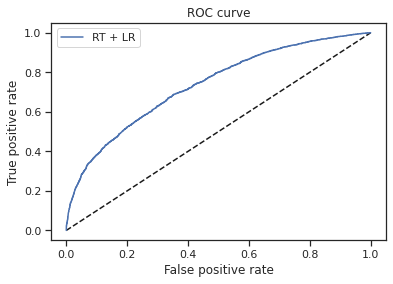

In [47]:
# Xây dựng pipeline và fit với tree-based
selected_columns = cols_categorical+cols_fts_num + cols_date + cols_date2

class ToString(BaseEstimator, TransformerMixin):
  '''Def 1 trans để convert các cột dạng số như categorical thành dạng cat => dùng được onehot'''
  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    X_ = X_.astype(str)
    return X_

class DateToNum(BaseEstimator, TransformerMixin):
  def __init__(self, format = '%Y-%m-%d' ):
    self.format = format
  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    X_ = X_.apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:10]) , format= self.format , errors= 'coerce')  
                              - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
                       , axis = 1)
    for i in X_.columns:
      X_[i+'year_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:10])
                                        , format= self.format , errors= 'coerce').dt.year -2010
      X_[i+'month_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:10])
                                        , format= self.format , errors= 'coerce').dt.month
      X_[i+'day_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:10])
                                        , format= self.format , errors= 'coerce').dt.day
    return X_

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    , ('to_string', ToString())
    , ('onehot', OrdinalEncoder(categories=categories_val))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
    # , ('standard', StandardScaler()) # Với tree thì không cần standard
])

datetime_pipe1 = Pipeline([
    ('datetime1', DateToNum(format='%Y-%m-%d'))
    # , ('standard', StandardScaler()) # Với tree thì không cần standard
    , ('imputer', SimpleImputer(strategy='mean'))
])

datetime_pipe2 = Pipeline([
    ('datetime2', DateToNum(format='%Y%m%d'))
    # , ('standard', StandardScaler()) # Với tree thì không cần standard
    , ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [
     ('cat', categorical_pipe, cols_categorical),
     ('num', numerical_pipe, cols_fts_num), 
     ('date1', datetime_pipe1, cols_date),
     ('date2', datetime_pipe2, cols_date2)
     ])

#xgb.XGBRegressor(objective="reg:linear", random_state=42, n_estimators =64, max_depth =7)
model =  LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=128,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1
        )
# GradientBoostingClassifier(random_state=42, 
#                                               max_depth = 7
#                                               # , loss = 'exponential' 
#                                               )

rf = Pipeline([
    ('preprocess', preprocessing),
    # ('pca', PCA(n_components = 100)),
    ('classifier', model)
])

rf.fit(X_train[selected_columns], y_train)
cv = StratifiedKFold()
score = cross_val_score(rf, X_train[selected_columns], y_train, cv=cv)

try:
  y_pred_rt = rf.predict_proba(X_test[selected_columns])[:, 1]
except:
  y_pred_rt = rf.predict(X_test[selected_columns])

fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
auc_s = auc(fpr_rt_lm, tpr_rt_lm)
print('AUC: ', auc_s)
print('Gini: ', 2*auc_s - 1)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
rf['pca'].explained_variance_ratio_

In [ ]:
# X_train[cols_date].apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:10]) , format=format , errors= 'coerce')  
#                               - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
#                        , axis = 1)

In [ ]:
# # SVM
# categorical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])
# numerical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean'))
#     , ('standard', StandardScaler()) # Với tree thì không cần standard
# ])

# preprocessing = ColumnTransformer(
#     [('cat', categorical_pipe, cols_categorical),
#      ('num', numerical_pipe, cols_fts_num)])

# pipeline = Pipeline([
#     ('preprocess', preprocessing),
#     ('classifier', SVC(probability = True))
# ])
# pipeline.fit(X_train, y_train)

# y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
# fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
# print('AUC: ', auc(fpr_rt_lm, tpr_rt_lm))

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# # TF nets
# class DenseTransformer(TransformerMixin):

#     def fit(self, X, y=None, **fit_params):
#         return self

#     def transform(self, X, y=None, **fit_params):
#         return X.todense()

# categorical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('to_string', ToString()),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])
# numerical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean'))
#     # , ('standard', StandardScaler()) # Với tree thì không cần standard
# ])

# preprocessing = ColumnTransformer(
#     [('cat', categorical_pipe, cols_categorical),
#      ('num', numerical_pipe, cols_fts_num)])

# def building_net_func():
#   net = Sequential(
#       [
#       BatchNormalization (),
#       Dense(1024, activation ='relu', kernel_initializer = 'he_normal'),
#       Dropout(0.5), 
#       BatchNormalization (),
#       Dense(128, activation ='relu', kernel_initializer = 'he_normal'),
#       Dropout(0.25), 
#       # BatchNormalization (),
#       # Dense(64, activation ='relu', kernel_initializer = 'he_normal'),
#       # Dropout(0.25), 
#       # BatchNormalization (),
#       Dense(16, activation ='relu', kernel_initializer = 'he_normal'),
#       BatchNormalization (),
#       Dense(1, activation ='sigmoid', kernel_initializer = 'he_normal')])
#   net.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = [ AUC() ] )
#   return net

# net = KerasRegressor(build_fn= building_net_func, verbose = 1)

# pipeline = Pipeline([
#     ('preprocess', preprocessing),
#     ('todense', DenseTransformer()),
#     ('classifier', net)
# ])
# pipeline.fit(
#     pd.concat([X_train, X_test])[selected_columns],
#     np.concatenate( [y_train, y_test])
#     , classifier__epochs = 8
#     , classifier__batch_size = 1024
#     , classifier__validation_split = 0.2)

# y_pred_rt = pipeline.predict(X_test)
# fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
# print('AUC: ', auc(fpr_rt_lm, tpr_rt_lm))

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

In [ ]:
prediction = pipeline.predict(predict_data[selected_columns])
res_df = pd.DataFrame({'id': predict_data.id, 'label': prediction})
res_df.to_csv('submission_net.csv', index=False)

NameError: ignored

In [ ]:
# ohe = (rf.named_steps['preprocess']
#          .named_transformers_['cat']
#          .named_steps['onehot'])
# feature_names = ohe.get_feature_names(input_features=cols_categorical)
# feature_names = np.r_[feature_names, cols_fts_num]

# tree_feature_importances = (
#     rf.named_steps['classifier'].feature_importances_)
# sorted_idx = tree_feature_importances.argsort()

# fts_im_num = 15
# y_ticks = np.arange(0, fts_im_num)
# fig, ax = plt.subplots()
# ax.barh(y_ticks, tree_feature_importances[sorted_idx[:fts_im_num]])
# ax.set_yticklabels(feature_names[sorted_idx[:fts_im_num]])
# ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
# fig.tight_layout()
# plt.show()

In [ ]:
sorted_idx[:15]

Dự đoán kết quả

In [ ]:
try:
  prediction = rf.predict_proba(predict_data[selected_columns])[:, 1]
except:
  prediction = rf.predict(predict_data[selected_columns])
res_df = pd.DataFrame({'id': predict_data.id, 'label': prediction})
res_df.to_csv('submission.csv', index=False)

In [ ]:
predict_

array([0.24803742, 0.31890366, 0.4028687 , ..., 0.10729143, 0.26460362,
       0.19883522])